# RecB dissociation rates in ΔrecA and RecB1080

Cipro: 30 ng/mL

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',
                            '230201_DT22', '230919_1',
                            '230126_DT21', '230919_2', '230920_2',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1',
                            '230802_DT21', '230913_2', '230914_2',
                            '240116_1', '240116_2', '240116_3',
                            '240117_1', '240117_2', '240117_3', '240117_4'],
                    groups=['WT, 0', 'WT, 0', 'WT, 0', 'WT, 0', 'WT, 0',
                            '$\Delta$recA, 0', '$\Delta$recA, 0',
                            'RecB1080, 0', 'RecB1080, 0', 'RecB1080, 0',
                            'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL', 'WT, 30 ng/mL',
                            '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL', '$\Delta$recA, 30 ng/mL',
                            'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL', 'RecB1080, 30 ng/mL',
                            'RecB1080-$\Delta$recA, 0', 'RecB1080-$\Delta$recA, 0', 'RecB1080-$\Delta$recA, 0',
                            'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL', 'RecB1080-$\Delta$recA, 30 ng/mL'],
                    filters={'all':'Frame < 50'},
                    metadata={'all':'DateTime'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230201_DT22: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230126_DT21: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230920_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230118_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230720_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230720_2: lo

In [ ]:
data.describe(object_name='Bacteria_large')

## Bleaching rate fit

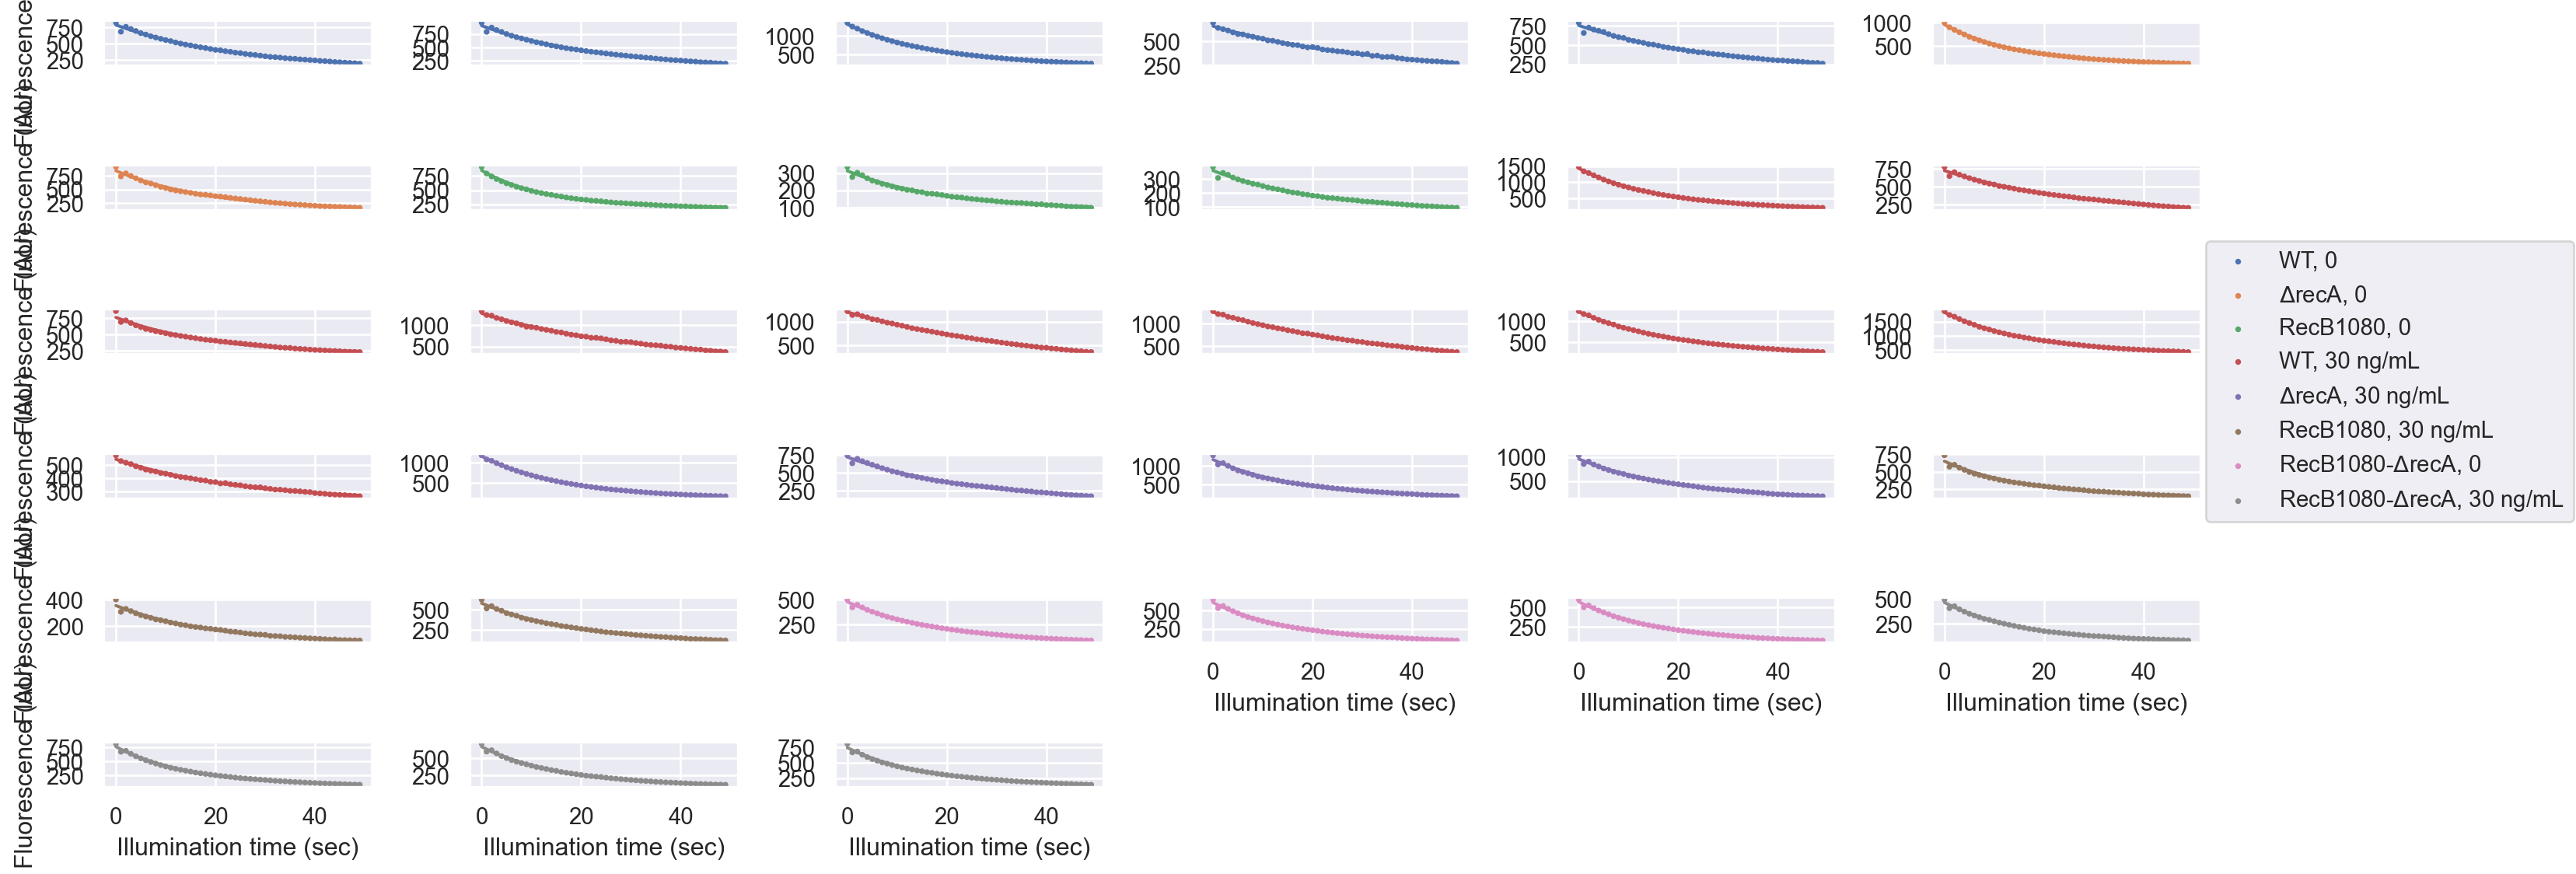

In [5]:
from pyberries.data import Fit
import seaborn.objects as so

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Strain', 'Cipro', 'Dataset'], model_type='monoexp_decay_offset', p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

(
    so.Plot(bleaching_fit.data, x='Frame', color='Group')
    .layout(size=(15, 6))
    .facet(col='Dataset', wrap=6)
    .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR')
    .add(so.Line(linestyle='-'), y='Fit', legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
)

### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

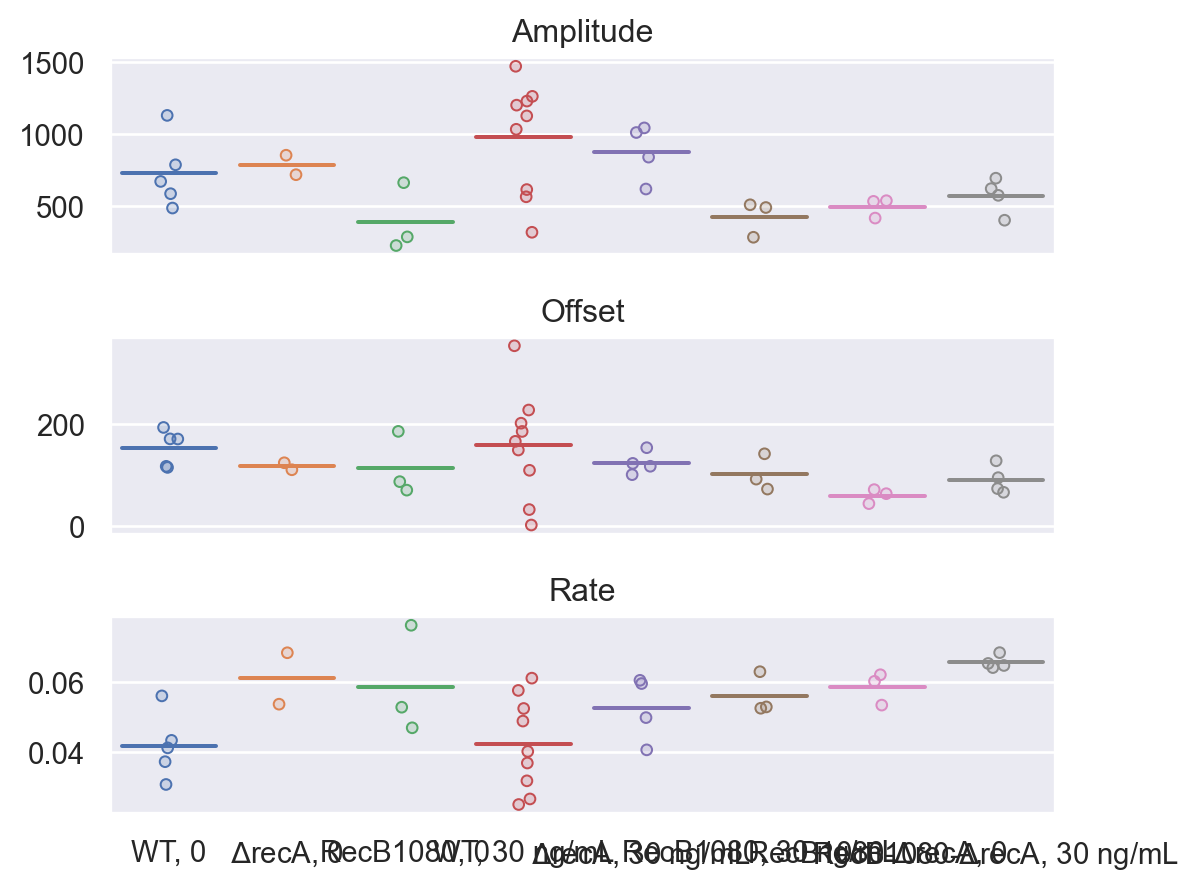

In [7]:
import seaborn.objects as so

bleaching_parameters = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])

(
    so.Plot(bleaching_parameters, x='Group', y='Fitted_param', color='Group')
    .facet(row='Param_name')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(), so.Agg(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

### Adjust bleahcing rates to frame time

The rate fitted above is a rate "per frame". Divide it by the frame interval (sec) to obtain the bleaching rate per second (adjusted rate).

In [8]:
bleaching_rates = (bleaching_parameters
                   .query('Param_name == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Fitted_param.div(2))
                   )

## RecB spot lifetime fit

In [10]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.1, 0.1])

Triple exponential fit

In [87]:
from pyberries.data import Fit, get_histogram
import numpy as np

def model(x, a, c, d, e, f):
    return a*np.exp(-0.75*x, dtype='float64') + c*np.exp(-d*x, dtype='float64') + e*np.exp(-f*x, dtype='float64')

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
triexp_fit = Fit(hist, x='TrackLength', y='proportion', model=model,
                 groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 0.5, 0.5, 0.1, 0.1])

Fit for dataset ('230725_1', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230725_2', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230126_DT23', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230719_2', 'WT, 0', 'WT', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230201_DT22', '$\\Delta$recA, 0', '$\\Delta$recA', '0') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230118_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit for dataset ('230201_DT23', 'WT, 30 ng/mL', 'WT', '30 ng/mL') failed: Optimal parameters not found:

### Inspect single datasets

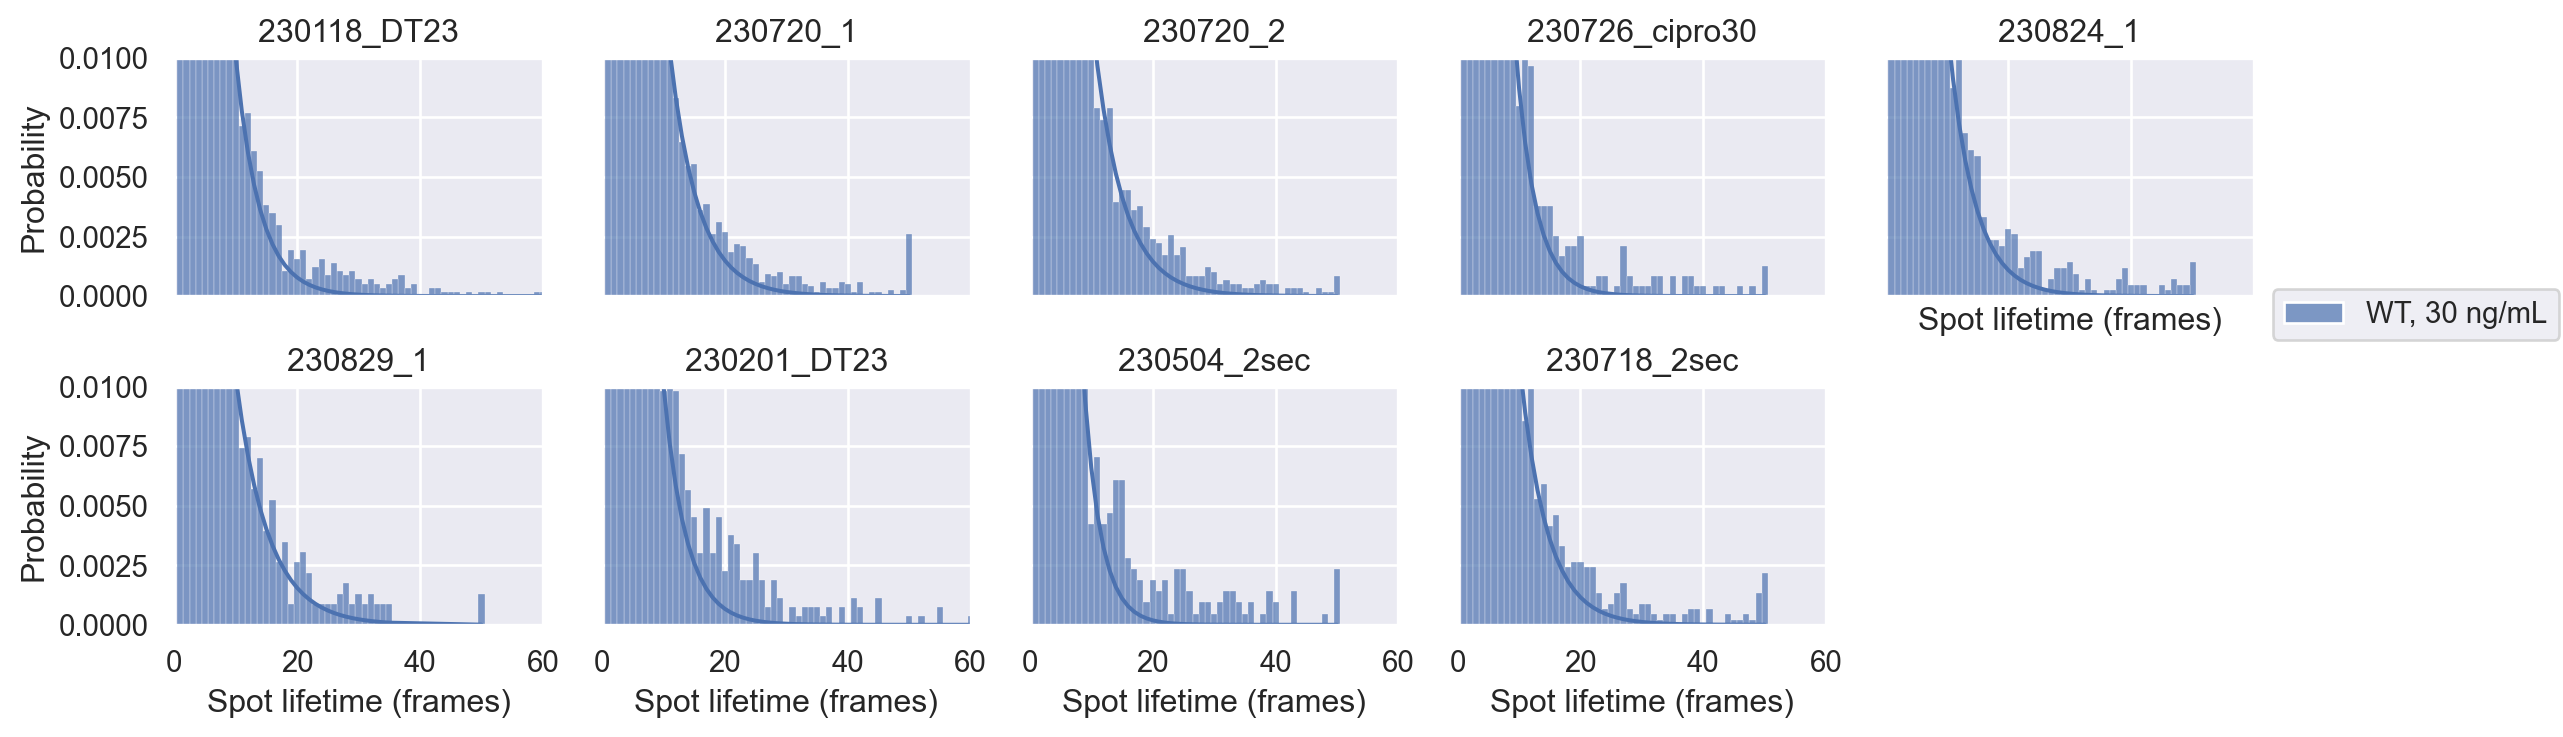

In [79]:
df = lifetime_fit.data.query('Group == "WT, 30 ng/mL"')

(
    so.Plot(df, x='TrackLength', color='Group')
    .layout(size=(12,4))
    .facet(col='Dataset', wrap=5)
    .add(so.Bars(), y='proportion')
    .add(so.Line(), y='Fit', legend=False)
    .limit(x=(0, 60), y=(None, 0.01))
    .label(x="Spot lifetime (frames)", y="Probability", color='')
)

## Dissociation rates

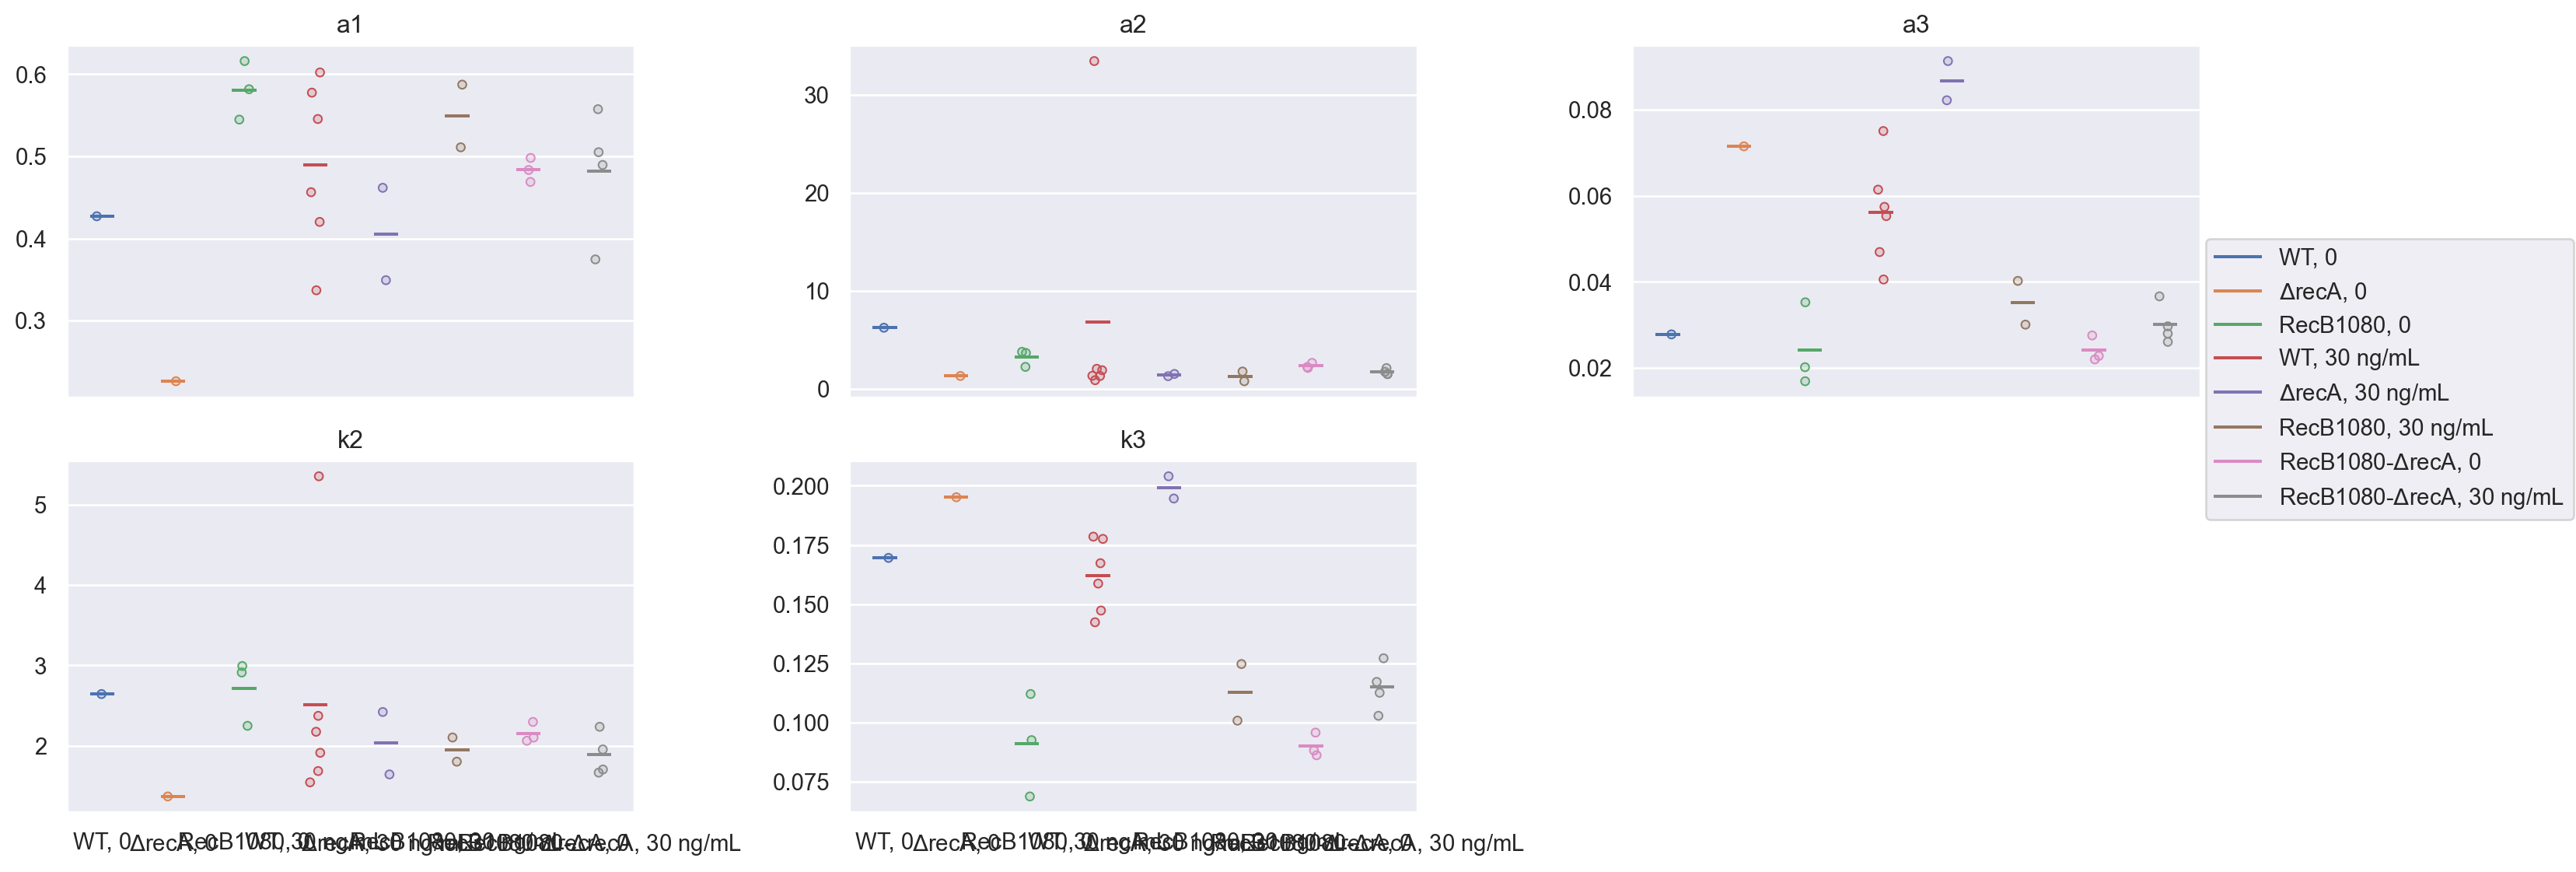

In [90]:
tri_rates = (triexp_fit
             .get_fit_parameters(param_names=['a1', 'a2', 'k2', 'a3', 'k3'])
             )

(
    so.Plot(tri_rates, x='Group', y='Fitted_param', color='Group')
    .layout(size=(15,6))
    .facet(col='Param_name', order=['a1', 'a2', 'a3', 'k2', 'k3'], wrap=3)
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'))
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
)

In [38]:
display(tri_rates.query('Group == "RecB1080-$\Delta$recA, 30 ng/mL"').groupby('Param_name')['Fitted_param'].agg('mean'))

Param_name
a1    0.481580
a2    1.725856
a3    0.030098
k2    1.892875
k3    0.114922
Name: Fitted_param, dtype: float64

In [86]:
from scipy.stats import chi2

for grp in triexp_fit.llf.keys():
    LR_statistic = -2*(lifetime_fit.llf[grp] - triexp_fit.llf[grp])
    p_val = chi2.sf(LR_statistic, 2)
    print(f'{grp}: p-value = {p_val}')

230725_1--WT, 0--WT--0: p-value = 1.3508170523270973e-09
230719_2--WT, 0--WT--0: p-value = 9.927388310454409e-06
230919_1--$\Delta$recA, 0--$\Delta$recA--0: p-value = 6.389477499480101e-05
230126_DT21--RecB1080, 0--RecB1080--0: p-value = 1.849280642121417e-19
230919_2--RecB1080, 0--RecB1080--0: p-value = 1.0810991280396e-11
230920_2--RecB1080, 0--RecB1080--0: p-value = 3.0463433819378647e-11
230720_1--WT, 30 ng/mL--WT--30 ng/mL: p-value = 1.0012863334979297e-10
230720_2--WT, 30 ng/mL--WT--30 ng/mL: p-value = 2.6362044932405793e-07
230824_1--WT, 30 ng/mL--WT--30 ng/mL: p-value = 4.220621723974089e-06
230829_1--WT, 30 ng/mL--WT--30 ng/mL: p-value = 0.0005265717750562085
230504_2sec--WT, 30 ng/mL--WT--30 ng/mL: p-value = 2.495377697551715e-05
230718_2sec--WT, 30 ng/mL--WT--30 ng/mL: p-value = 1.5004636924288415e-12
230802_DT22--$\Delta$recA, 30 ng/mL--$\Delta$recA--30 ng/mL: p-value = 2.665107521312758e-07
230808_DT22--$\Delta$recA, 30 ng/mL--$\Delta$recA--30 ng/mL: p-value = 8.7562978657

In [11]:
rates = (lifetime_fit.get_rates(dt=2, offset=list(bleaching_rates.Adjusted_rate))
         .assign(Lifetime=lambda df: 1/df.Rate,
                 Population=lambda df: df.Population*100
                 )
         )

print('Average rates:')
display(rates.groupby(['Group', 'Rate_type'], sort=False, observed=True)[['Lifetime', 'Population']].agg(['mean', 'std']))

Average rates:


Lifetime           Population  \
                                                mean       std       mean   
Group                           Rate_type                                   
WT, 0                           Fast        1.238334  0.204554  97.378383   
                                Slow        7.145018  1.195796   2.621617   
$\Delta$recA, 0                 Fast        1.453020  0.337244  94.289329   
                                Slow       10.058466  2.873898   5.710671   
RecB1080, 0                     Fast        1.598728  0.073514  95.888676   
                                Slow       15.896379  2.269352   4.111324   
WT, 30 ng/mL                    Fast        1.487330  0.227199  92.478296   
                                Slow        9.829567  1.736276   7.521704   
$\Delta$recA, 30 ng/mL          Fast        1.722114  0.183099  87.472109   
                                Slow       10.738386  1.881586  12.527891   
RecB1080, 30 ng/mL              Fast        1.756075  0.252336  94.142745   
                                Slow       15.181802  4.997084   5.857255   
RecB1080-$\Delta$recA, 0        Fast        1.546242  0.032543  96.887379   
                                Slow       19.368319  1.649076   3.112621   
RecB1080-$\Delta$recA, 30 ng/mL Fast        1.666441  0.052237  95.994758   
                                Slow       17.010691  3.007589   4.005242   

                                                     
                                                std  
Group                           Rate_type            
WT, 0                           Fast       0.724237  
                                Slow       0.724237  
$\Delta$recA, 0                 Fast       0.041308  
                                Slow       0.041308  
RecB1080, 0                     Fast       1.091660  
                                Slow       1.091660  
WT, 30 ng/mL                    Fast       1.950158  
                                Slow       1.950158  
$\Delta$recA, 30 ng/mL          Fast       3.930718  
                                Slow       3.930718  
RecB1080, 30 ng/mL              Fast       1.717963  
                                Slow       1.717963  
RecB1080-$\Delta$recA, 0        Fast       0.285590  
                                Slow       0.285590  
RecB1080-$\Delta$recA, 30 ng/mL Fast       0.784826  
                                Slow       0.784826

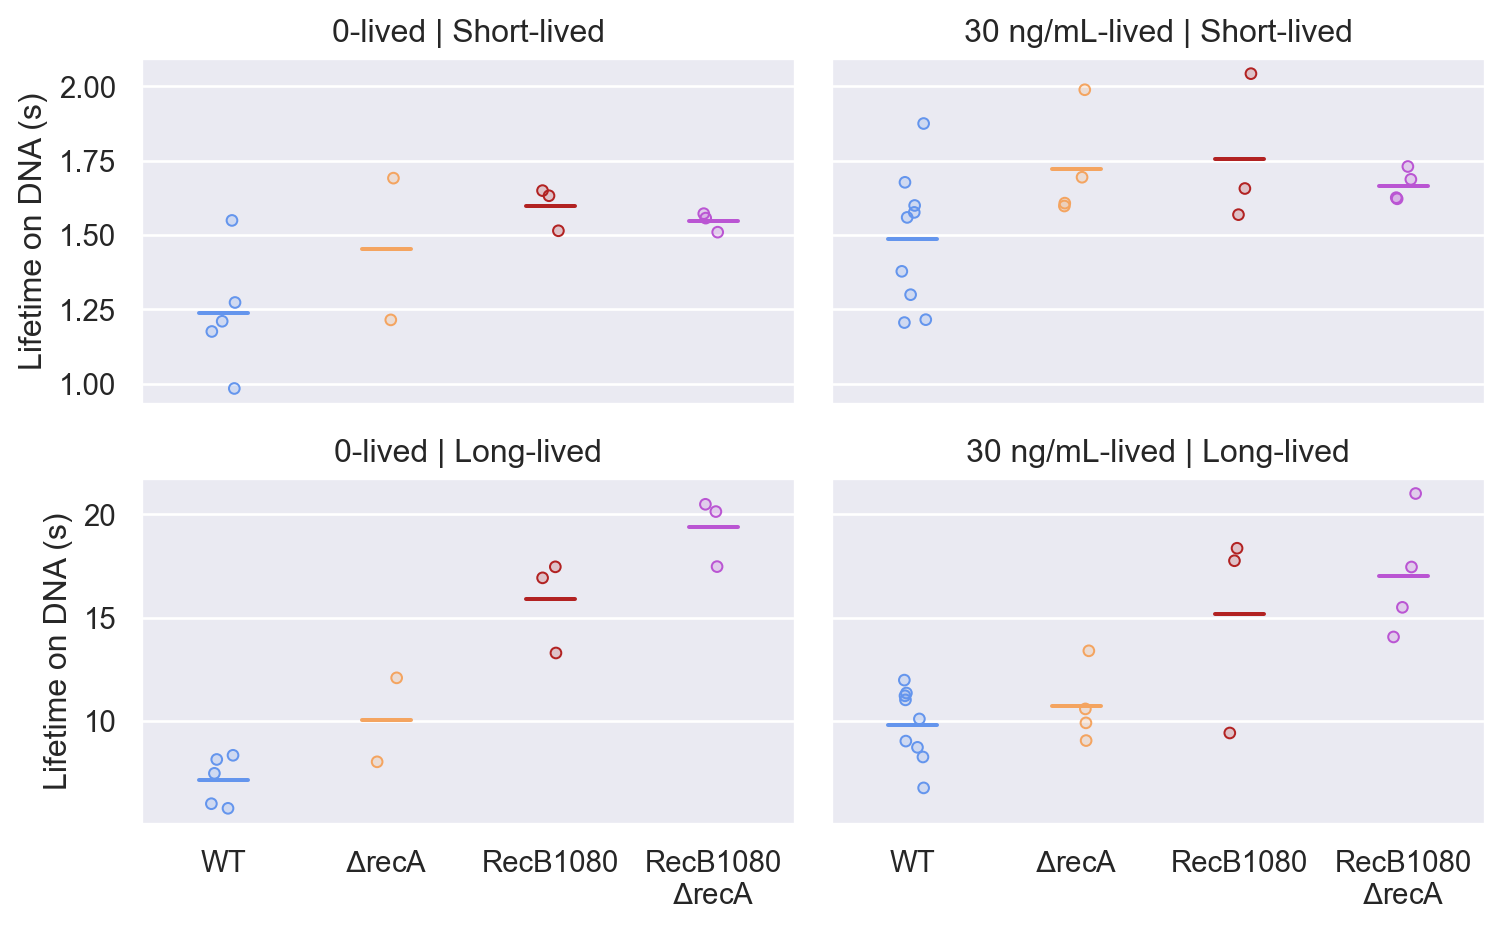

In [12]:
rates = rates.replace({'Fast':'Short', 'Slow':'Long', 'RecB1080-$\Delta$recA':'RecB1080\n$\Delta$recA'})

(
    so.Plot(rates, x='Strain', y='Lifetime', color='Strain')
    .layout(size=(8, 5))
    .facet(row='Rate_type', col='Cipro')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'), legend=False)
    .scale(color=['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'])
    .share(y='row')
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="{}-lived".format)
    # .save(loc='M:\\Figures\\RecB_article_figures\\4_Mutants\\RecB_dissociation_rates.svg', format='svg', bbox_inches='tight')
)

### Inspect single datasets:

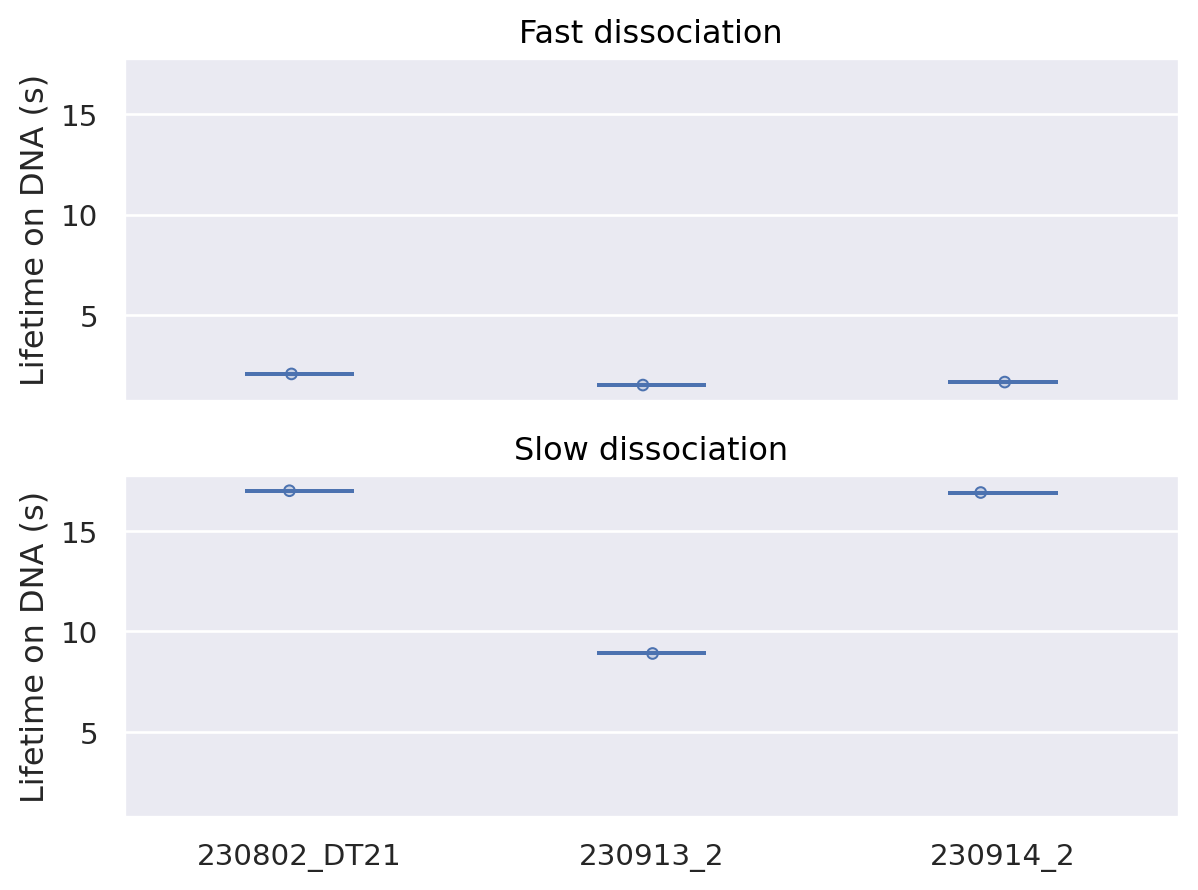

In [55]:
df = rates.query('Group == "RecB1080"')

(
    so.Plot(df, x='Dataset', y='Lifetime', color='Group')
    .facet(row='Rate_type')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(width=.3), so.Agg('mean'), legend=False)
    .share(y=True)
    .limit(y=(None, None))
    .label(x="", y="Lifetime on DNA (s)", color='', title="{} dissociation".format)
)

In [14]:
from pyberries.data import get_model
import pandas as pd

monoexp_decay = get_model('monoexp_decay')

fit_params = lifetime_fit.get_fit_parameters(param_names=['a1', 'b1', 'a2', 'b2'])

lifetime_fit.data[['Fit_fast', 'Fit_slow', 'p_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow', 'p_slow'])
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = fit_params.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[0], b=params.Fitted_param.iloc[1]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[2], b=params.Fitted_param.iloc[3]),
                  p_slow = lambda df: df.Fit_slow/(df.Fit_slow + df.Fit_fast))
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

data = data.add_from_child(object_name='Bacteria_large', child='RecB_spots', col='TrackLength', multiple='max', rename='max_lifetime')

### Number of spots per cell area

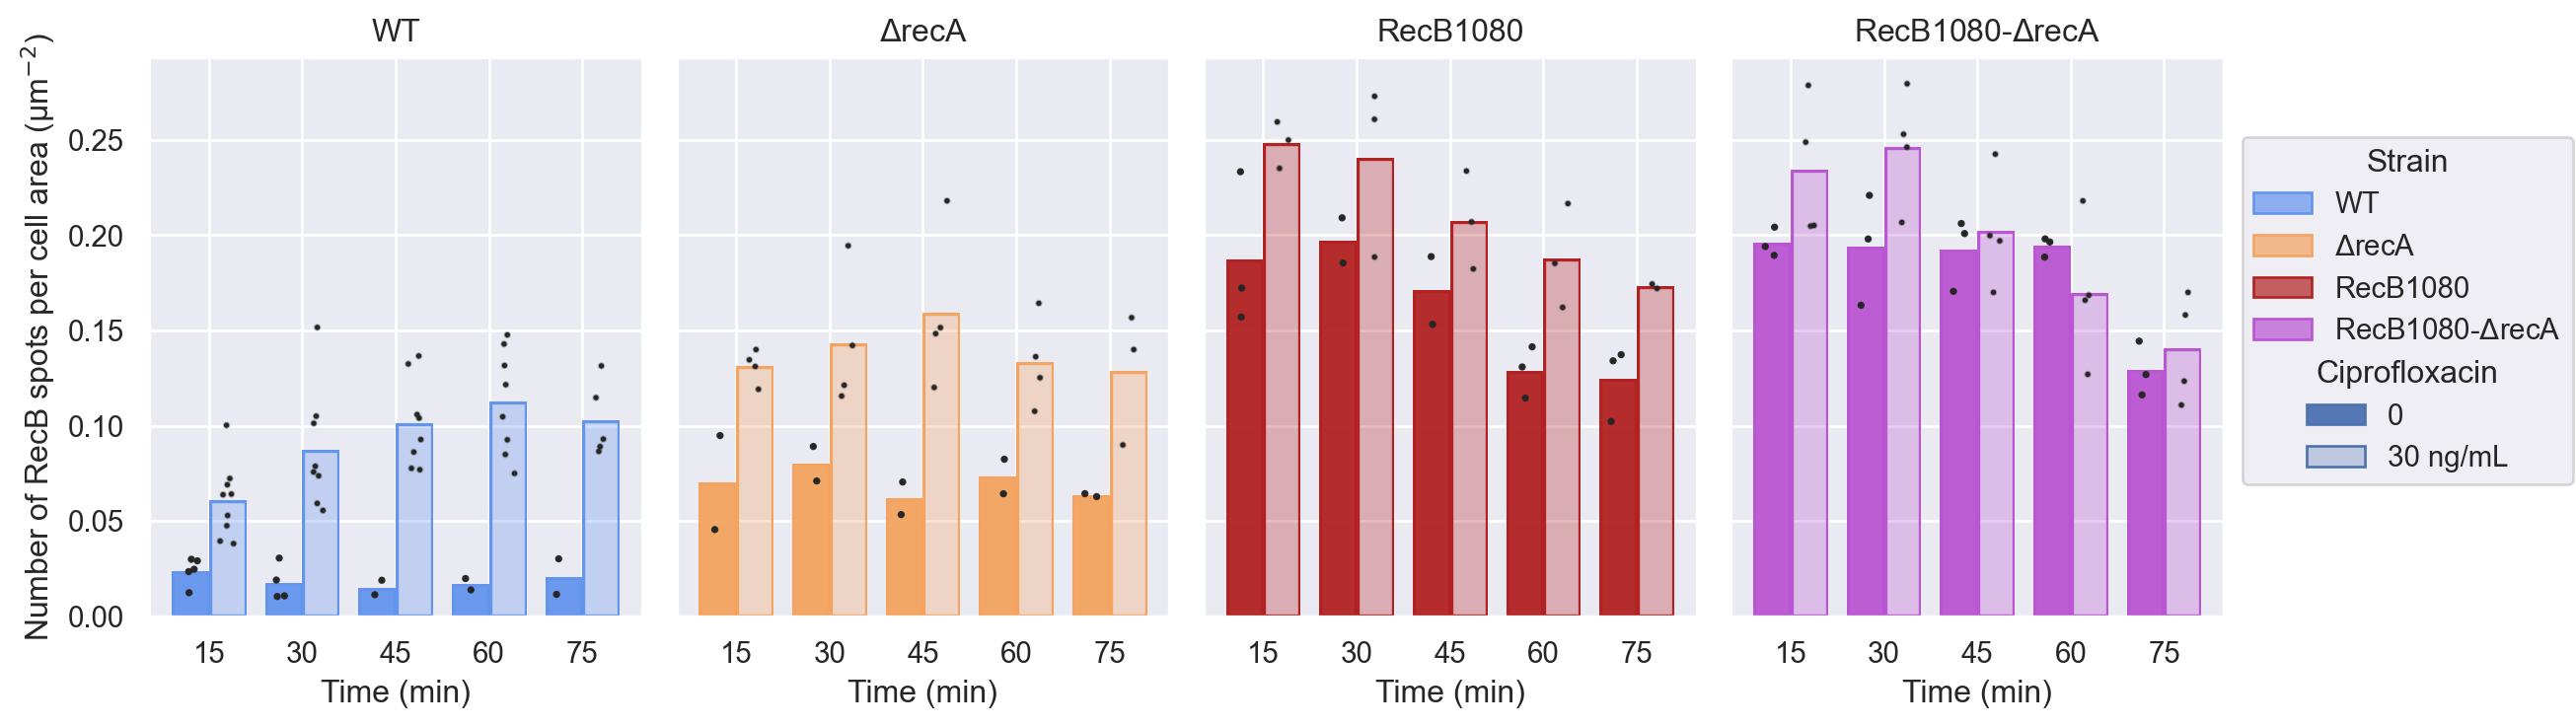

In [21]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots',
              long_spot=lambda df: df.TrackLength.ge(8).replace({True:'Long', False:'Short'})
              )
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'Area': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area)
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'Time_min_bin'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells)
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Strain', alpha='Cipro')
 .layout(size=(12, 4))
 .facet(col='Strain', order={'col':['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']})
 .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
 .scale(alpha=so.Nominal(),
        color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'], order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']),
        x=so.Continuous().tick(every=15)
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", color='Strain', alpha='Ciprofloxacin')
#  .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

#### More compact graph

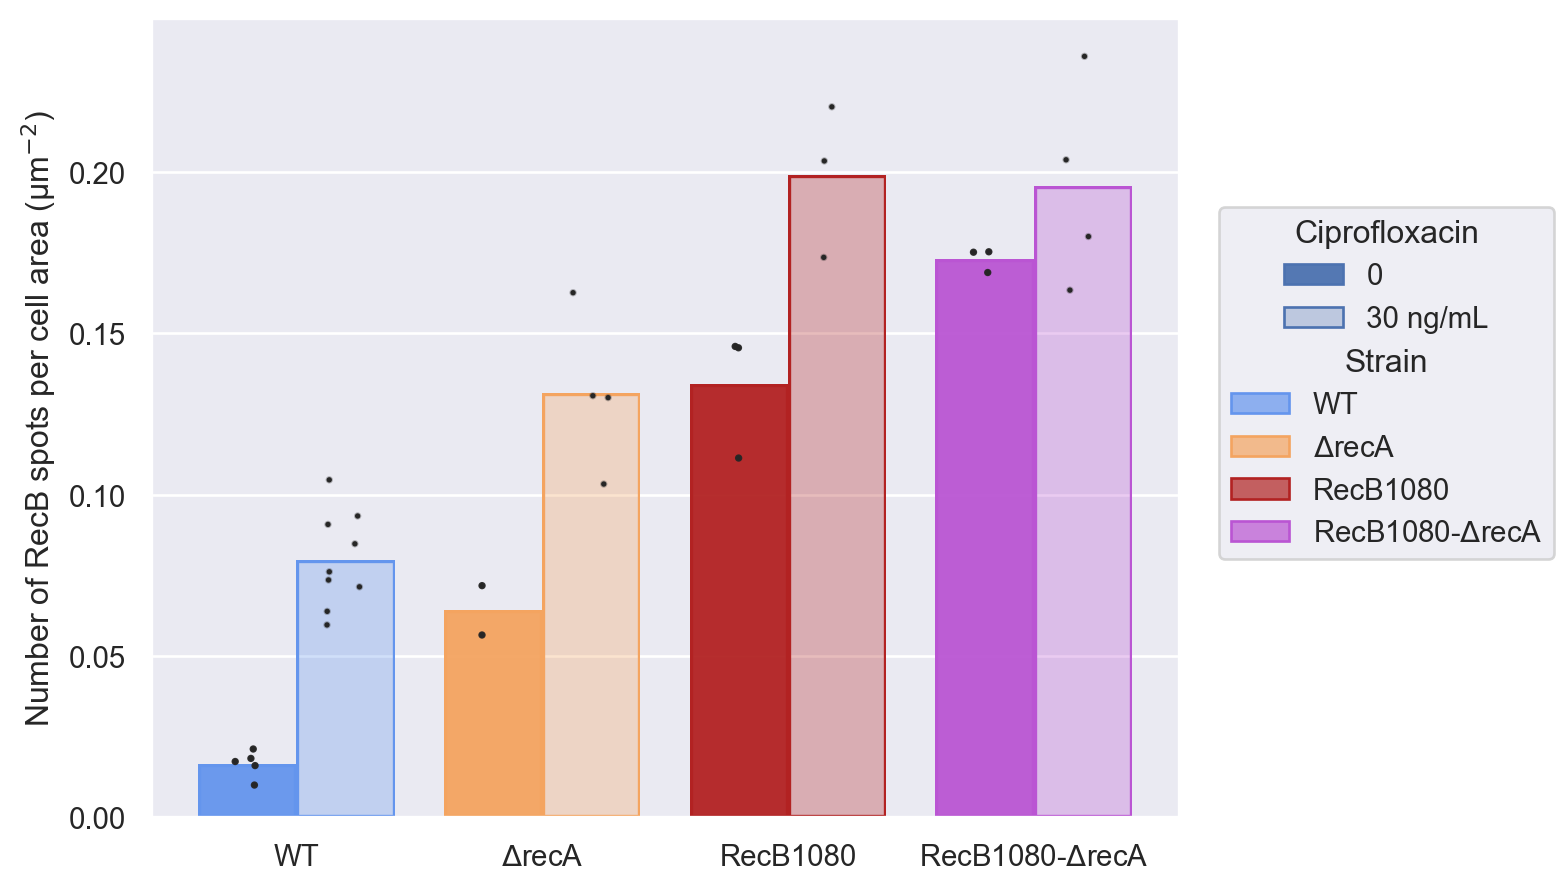

In [17]:
import seaborn.objects as so

df = (data
      .assign(object_name='RecB_spots',
               long_spot=lambda df: df.TrackLength.ge(8).replace({True:'Long', False:'Short'})
               )
      .get_parent_indices(object_name='RecB_spots')
      .RecB_spots
      .groupby(by=['Strain', 'Cipro', 'Dataset', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'SpineLength': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.SpineLength)
      .groupby(by=['Strain', 'Cipro', 'long_spot', 'Dataset'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby('Dataset')['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on='Dataset',
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,
              norm_count=lambda df: df.norm_count / df.nCells
              )
      .query('long_spot == "Long"')
      )

(
 so.Plot(df, x='Strain', y='norm_count', alpha='Cipro', color='Strain')
 .add(so.Bar(), so.Agg(), so.Dodge(by=['alpha']))
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), so.Dodge(by=['alpha']), legend=False)
 .scale(alpha=so.Nominal(),
        color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'], order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA']),
        x=so.Nominal(order=['WT', '$\Delta$recA', 'RecB1080', 'RecB1080-$\Delta$recA'])
        )
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x='', y='Number of RecB spots per cell area (µm$^{-2}$)', title='', color='Strain', alpha='Ciprofloxacin')
#  .save(loc='M:\\Figures\\RecB_article_figures\\4_Mutants\\RecB_counting.svg', format='svg', bbox_inches='tight')
 )

## RecB position in the cell

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

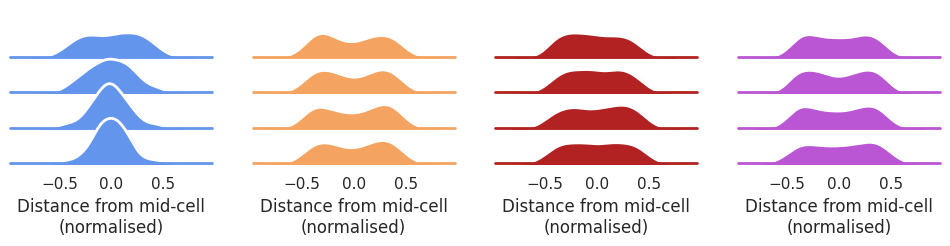

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5)
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=20, binlabels='left')
      .set_type(object_name='RecB_spots', type_dict={'Time_min_bin':'int'})
      .RecB_spots
      .query('Time_min_bin < 95 and Cipro == "30 ng/mL" and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette=['cornflowerblue', 'sandybrown', 'firebrick', 'mediumorchid'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "midCellDist",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "midCellDist", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

# g.map(label, "midCellDist")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)

# plt.savefig(fname='M:\\Figures\\RecB_article_figures\\4_Mutants\\RecB_position.svg', format='svg', bbox_inches='tight')